<a href="https://colab.research.google.com/github/sidt-ai/data-science-competitions/blob/main/dphi/ds74-smoker-status-prediction/notebooks/01_eda_and_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import gc
import time
import warnings
import subprocess

gc.enable()
warnings.filterwarnings('ignore')

In [ ]:
%%capture
!pip install xgboost==1.6.0

In [ ]:
import numpy as np
from scipy.stats import mode, ttest_ind
import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.max_columns', None)

import xgboost as xgb

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
SEED = 2311

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
#Check GPU availability
try:
    subprocess.check_output('nvidia-smi')
    GPU = True
except Exception:
    GPU = False

print(f'GPU available: {GPU}')

GPU available: True


In [ ]:
train_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/dphi/ds74-smoker-status-prediction/data/raw/train_dataset.csv'
test_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/dphi/ds74-smoker-status-prediction/data/raw/test_dataset.csv'

In [ ]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# EDA + Preprocessing

In [ ]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,97,239,153,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,88,211,128,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,80,193,120,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,249,210,366,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,100,179,200,47,92,14.9,1,1.2,26,28,15,0,0


## Feature types

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

In [ ]:
train.nunique()

age                     14
height(cm)              13
weight(kg)              22
waist(cm)              545
eyesight(left)          19
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               125
relaxation              94
fasting blood sugar    258
Cholesterol            279
triglyceride           389
HDL                    122
LDL                    286
hemoglobin             143
Urine protein            6
serum creatinine        34
AST                    195
ALT                    230
Gtp                    439
dental caries            2
smoking                  2
dtype: int64

In [ ]:
cat_features = ['hearing(left)', 'hearing(right)', 'dental caries']
TARGET = 'smoking'

In [ ]:
features = list(test.columns)
num_features = [f for f in features if f not in cat_features]

In [ ]:
for col in cat_features:
    print(train[col].unique())

[1 2]
[1 2]
[1 0]


In [ ]:
train[cat_features] = train[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

## Feature distributions

In [ ]:
def plot_grouped(col, discrete=True):
    
    plt.figure(figsize=(20, 6))
    
    if discrete:
        ax = sns.countplot(x=col, data=train, hue=TARGET)
    else:
        ax = sns.kdeplot(x=col, data=train, hue=TARGET)
    
    ax.set_title('\'' + col + '\' distribution grouped by target column', 
                 fontsize=15, fontweight='bold')   
    ax.set_xlabel(col, fontsize=10, fontweight='bold')
    ax.set_ylabel('count', fontsize=10, fontweight='bold')
    for p in ax.patches:
        val = 0 if np.isnan(p.get_height()) else p.get_height()
        ax.text(
            (p.get_x() + p.get_width()/2), (val + 0.5), 
            int(val), 
            horizontalalignment='center', fontsize=9)
        
    plt.show()

### Age

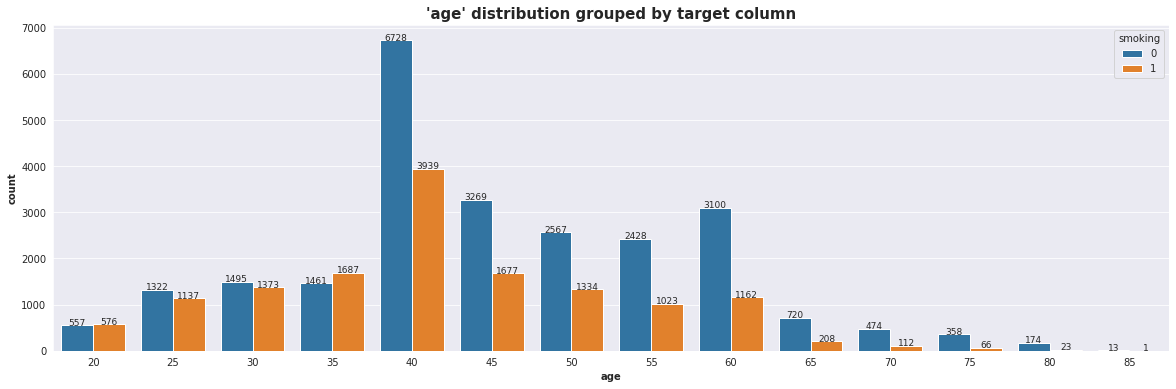

In [ ]:
plot_grouped('age')

### Height

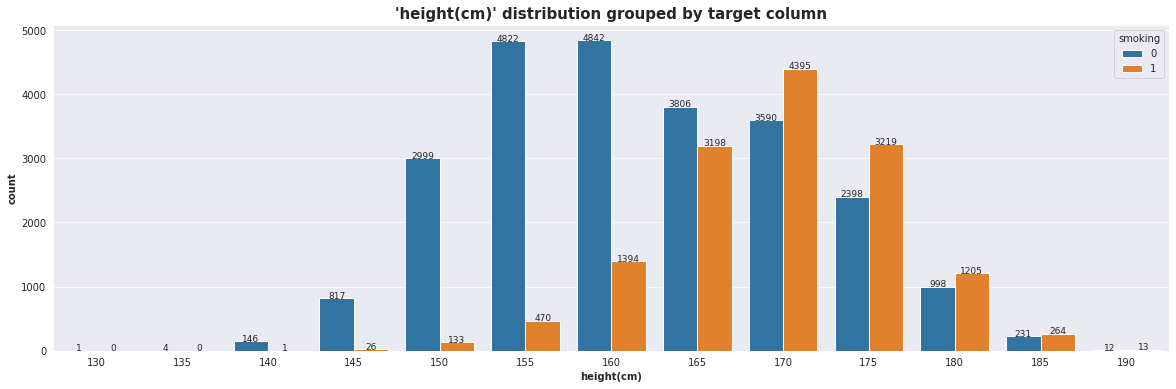

In [ ]:
plot_grouped('height(cm)')

### Weight

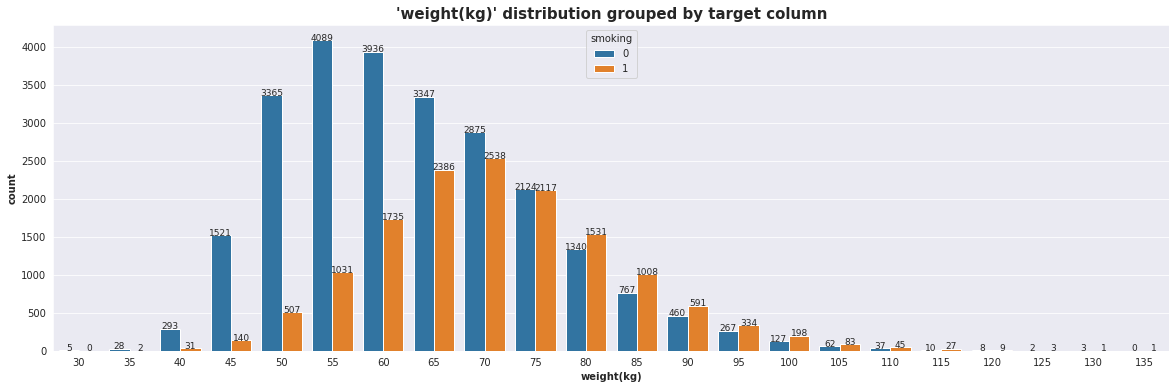

In [ ]:
plot_grouped('weight(kg)')

### Waist

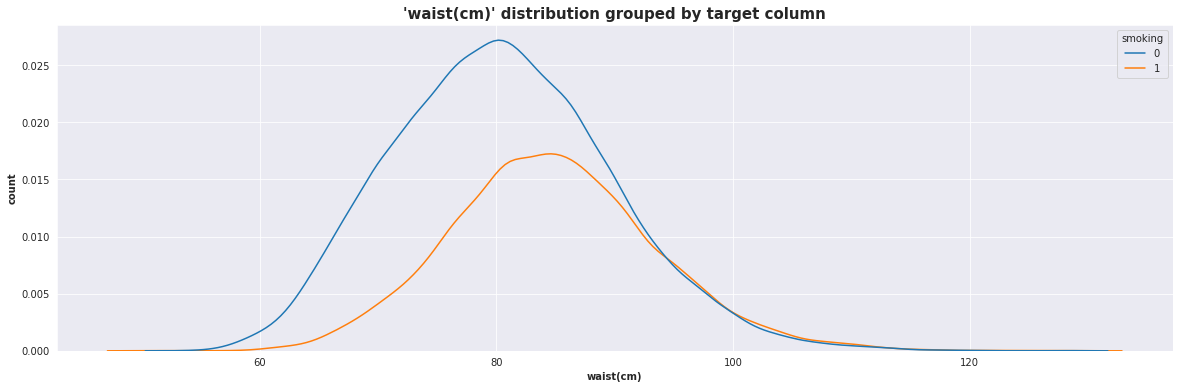

In [ ]:
plot_grouped('waist(cm)', discrete=False)

### Eyesight

In [ ]:
print(f"train set:{sorted(train['eyesight(left)'].unique())}")
print(f"test set: {sorted(test['eyesight(left)'].unique())}")

train set:[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.6, 1.8, 1.9, 2.0, 9.9]
test set: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.6, 1.9, 2.0, 9.9]


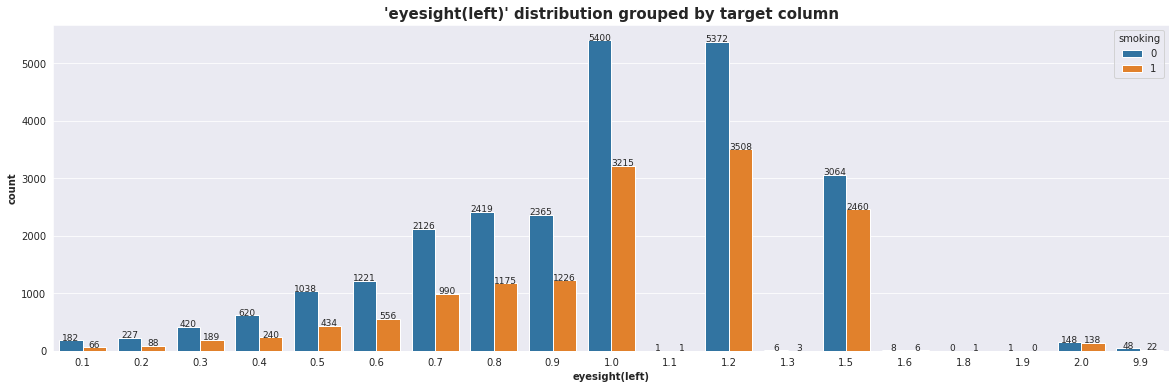

In [ ]:
plot_grouped('eyesight(left)')

In [ ]:
print(f"train set:{sorted(train['eyesight(right)'].unique())}")
print(f"test set: {sorted(test['eyesight(right)'].unique())}")

train set:[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.6, 2.0, 9.9]
test set: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.3, 1.5, 1.6, 2.0, 9.9]


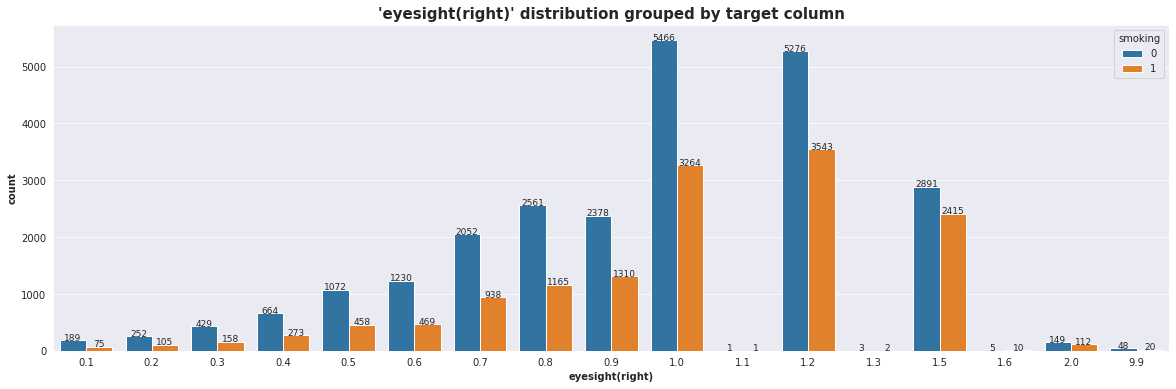

In [ ]:
plot_grouped('eyesight(right)')

### Hearing

In [ ]:
train.groupby('hearing(left)')['smoking'].value_counts()

hearing(left)  smoking
1              0          23975
               1          14020
2              0            691
               1            298
Name: smoking, dtype: int64

In [ ]:
train.groupby('hearing(left)')['smoking'].value_counts(normalize=True)

hearing(left)  smoking
1              0          0.6310
               1          0.3690
2              0          0.6987
               1          0.3013
Name: smoking, dtype: float64

In [ ]:
train.groupby('hearing(right)')['smoking'].value_counts()

hearing(right)  smoking
1               0          23963
                1          14000
2               0            703
                1            318
Name: smoking, dtype: int64

In [ ]:
train.groupby('hearing(right)')['smoking'].value_counts(normalize=True)

hearing(right)  smoking
1               0          0.6312
                1          0.3688
2               0          0.6885
                1          0.3115
Name: smoking, dtype: float64

Similar distriutions for both target classes.

### Systolic

In [ ]:
train['systolic'].nunique()

125

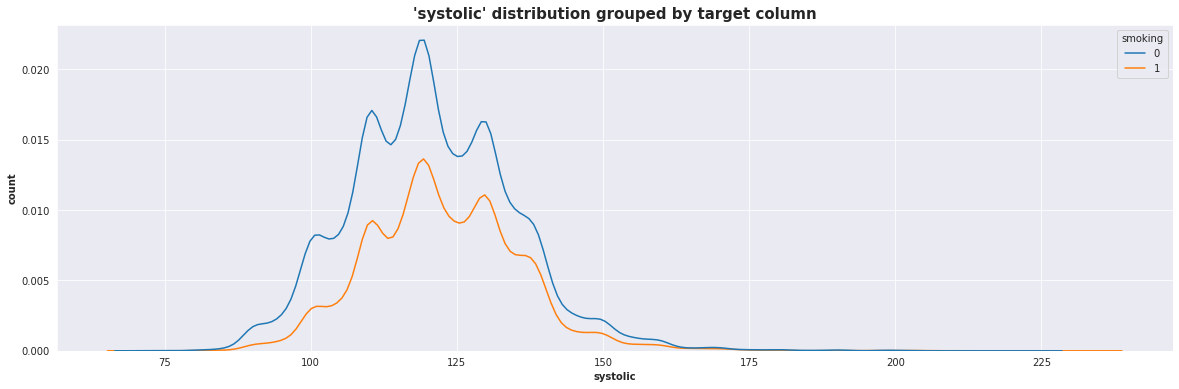

In [ ]:
plot_grouped('systolic', discrete=False)

### Relaxation

In [ ]:
train['relaxation'].nunique()

94

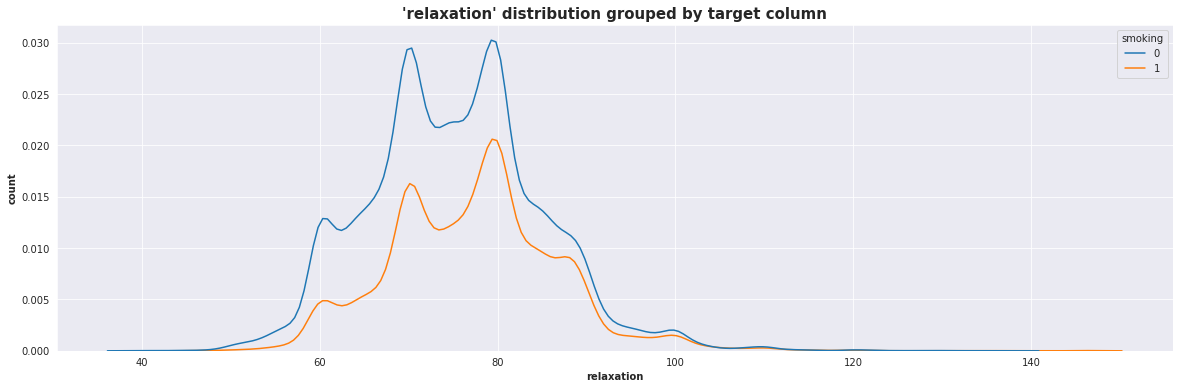

In [ ]:
plot_grouped('relaxation', discrete=False)

### Fasting blood sugar

In [ ]:
train['fasting blood sugar'].nunique()

258

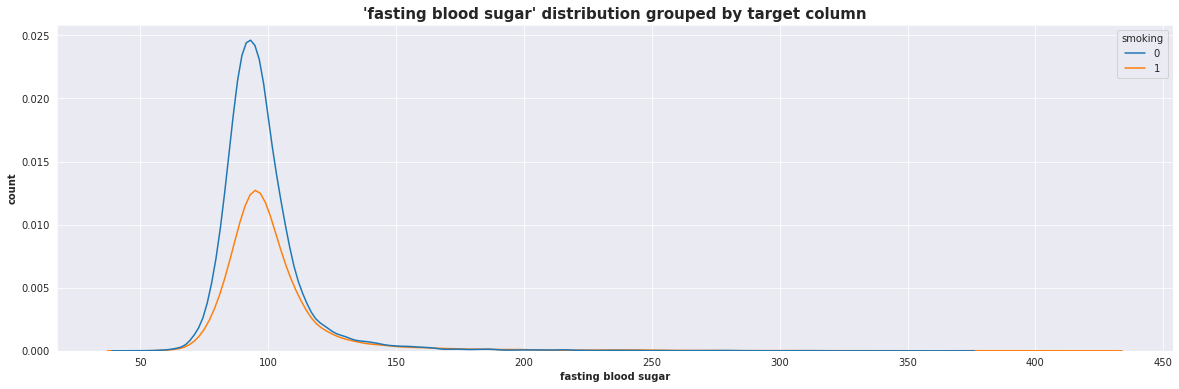

In [ ]:
plot_grouped('fasting blood sugar', discrete=False)

In [ ]:
len(train.loc[train['fasting blood sugar'] > 175]) / len(train) * 100

1.2774471578083317

In [ ]:
train_clip = train.loc[train['fasting blood sugar'] < 175]

### Cholestrol

In [ ]:
train['Cholesterol'].nunique()

279

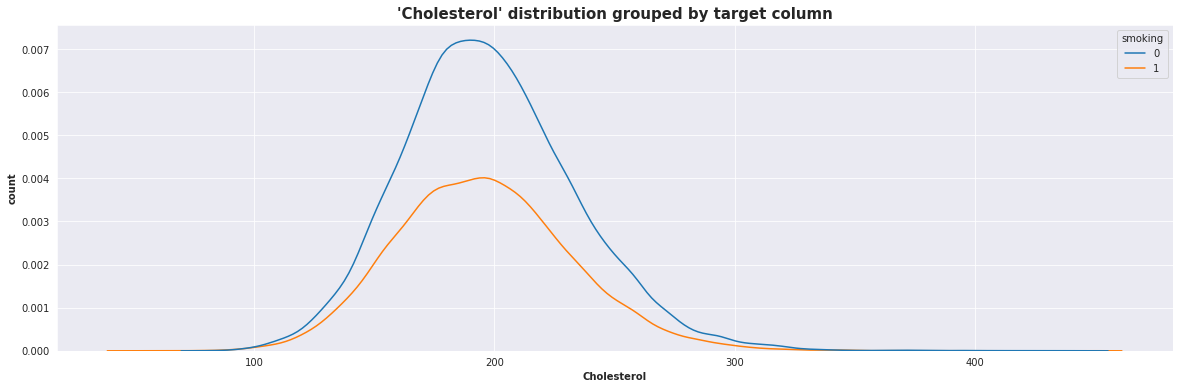

In [ ]:
plot_grouped('Cholesterol', discrete=False)

### HDL

In [ ]:
train['HDL'].nunique()

122

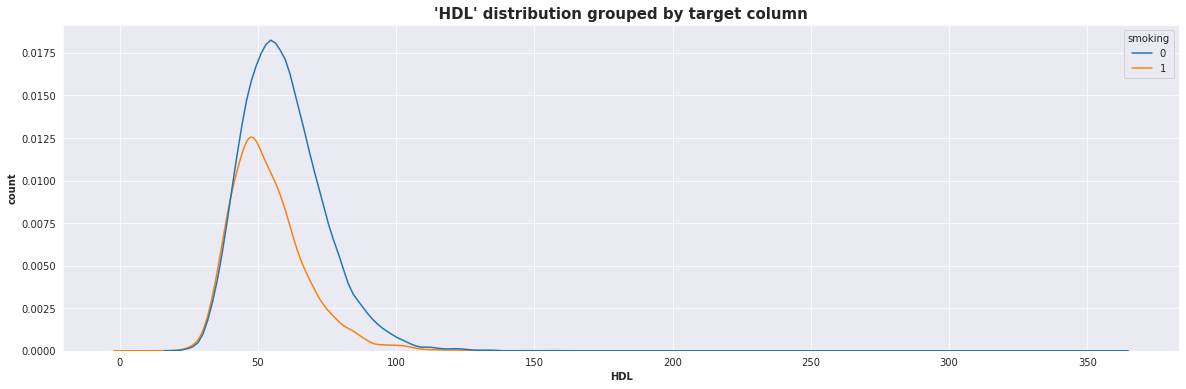

In [ ]:
plot_grouped('HDL', discrete=False)

Low HDL -> higher chance

### LDL

In [ ]:
train['LDL'].nunique()

286

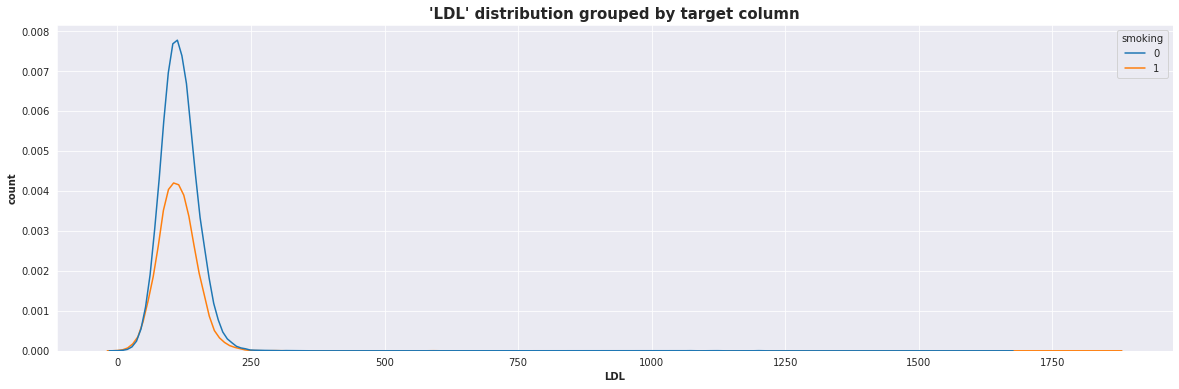

In [ ]:
plot_grouped('LDL', discrete=False)

Similar to HDL. Separation between classes increases as LDL increases.

### Triglyceride

In [ ]:
train['triglyceride'].nunique()

389

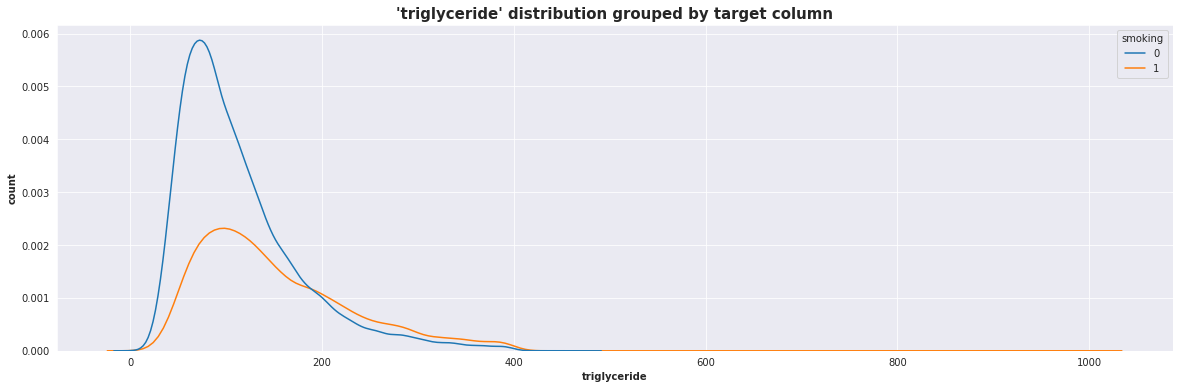

In [ ]:
plot_grouped('triglyceride', discrete=False)

Higher triglyceride levels -> more chances of positive class

### hemoglobin

In [ ]:
train['hemoglobin'].nunique()

143

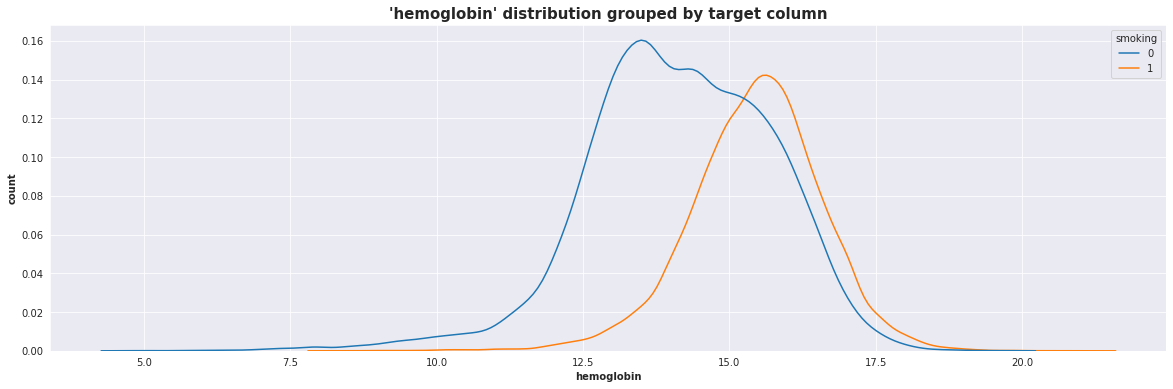

In [ ]:
plot_grouped('hemoglobin', discrete=False)

High hemoglobin level beyond a limit -> very high chances of positive class

### Urine protein

In [ ]:
train['Urine protein'].unique(), test['Urine protein'].unique()

(array([1, 3, 2, 5, 4, 6]), array([1, 3, 2, 4, 5, 6]))

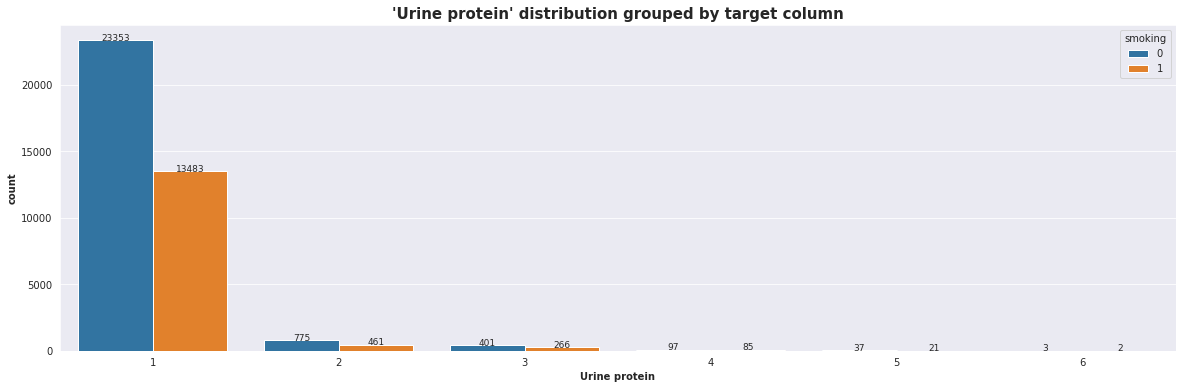

In [ ]:
plot_grouped('Urine protein')

In [ ]:
train['Urine protein'].value_counts(normalize=True)

1    0.9449
2    0.0317
3    0.0171
4    0.0047
5    0.0015
6    0.0001
Name: Urine protein, dtype: float64

In [ ]:
train.groupby('Urine protein')['smoking'].value_counts()

Urine protein  smoking
1              0          23353
               1          13483
2              0            775
               1            461
3              0            401
               1            266
4              0             97
               1             85
5              0             37
               1             21
6              0              3
               1              2
Name: smoking, dtype: int64

In [ ]:
train.groupby('Urine protein')['smoking'].value_counts(normalize=True)

Urine protein  smoking
1              0          0.6340
               1          0.3660
2              0          0.6270
               1          0.3730
3              0          0.6012
               1          0.3988
4              0          0.5330
               1          0.4670
5              0          0.6379
               1          0.3621
6              0          0.6000
               1          0.4000
Name: smoking, dtype: float64

### serum creatinine

In [ ]:
train['serum creatinine'].nunique()

34

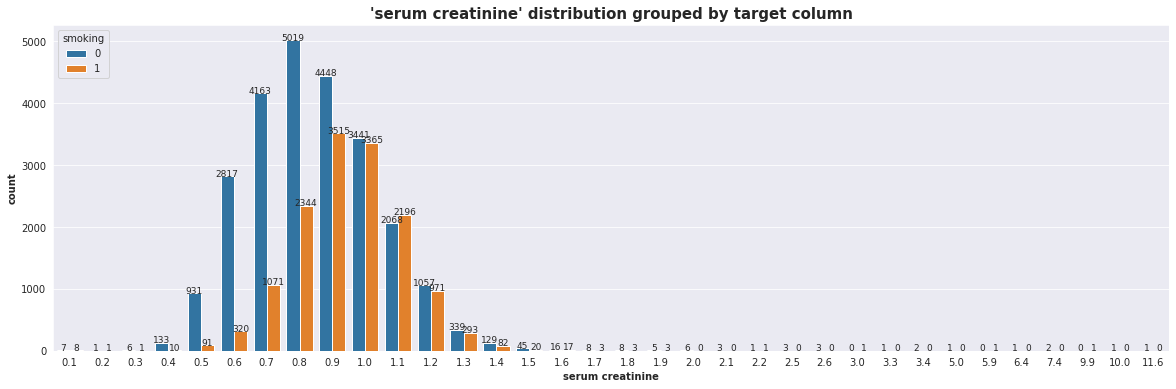

In [ ]:
plot_grouped('serum creatinine')

High serum creatinine -> higher chance of positive class

### AST

In [ ]:
train['AST'].nunique()

195

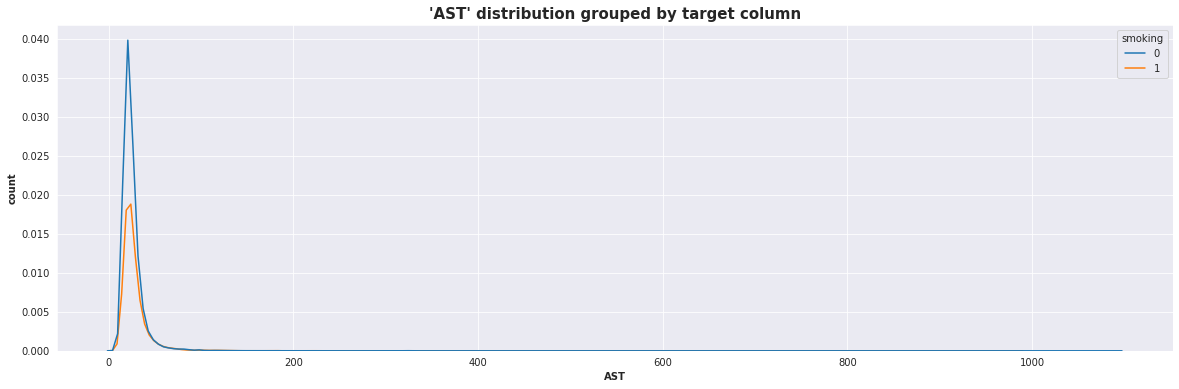

In [ ]:
plot_grouped('AST', discrete=False)

In [ ]:
len(train.loc[train['AST'] > 80]) / len(train) * 100

0.9747588754360763

Only ~1% of rows have AST value above 80, with the maximum being above 1000. Outlier clipping will be required here.

In [ ]:
train_clip = train_clip.loc[train_clip['AST'] < 80]

### ALT

In [ ]:
train['ALT'].nunique()

230

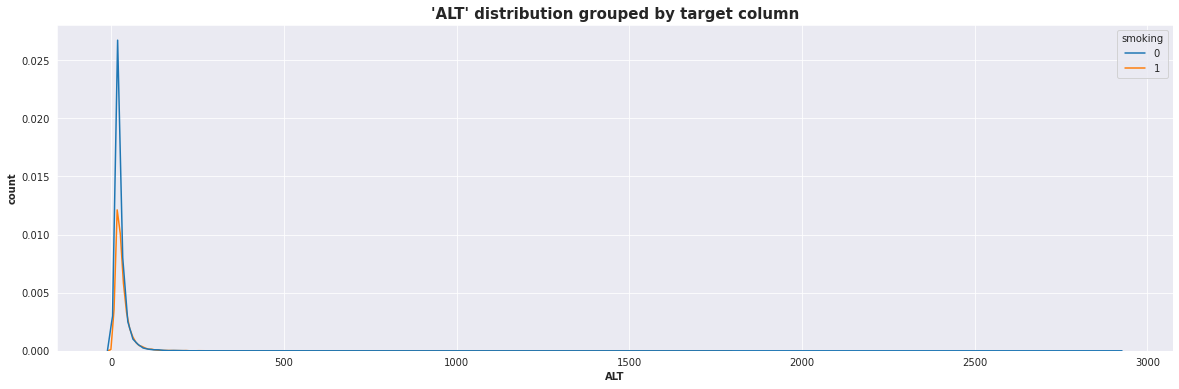

In [ ]:
plot_grouped('ALT', discrete=False)

In [ ]:
len(train.loc[train['ALT'] > 100]) / len(train) * 100

1.313359326903345

In [ ]:
len(train_clip.loc[train_clip['ALT'] > 100]) / len(train_clip) * 100

0.8031074484279039

In [ ]:
train_clip = train_clip.loc[train_clip['ALT'] < 100]

### Gtp

In [ ]:
train['Gtp'].nunique()

439

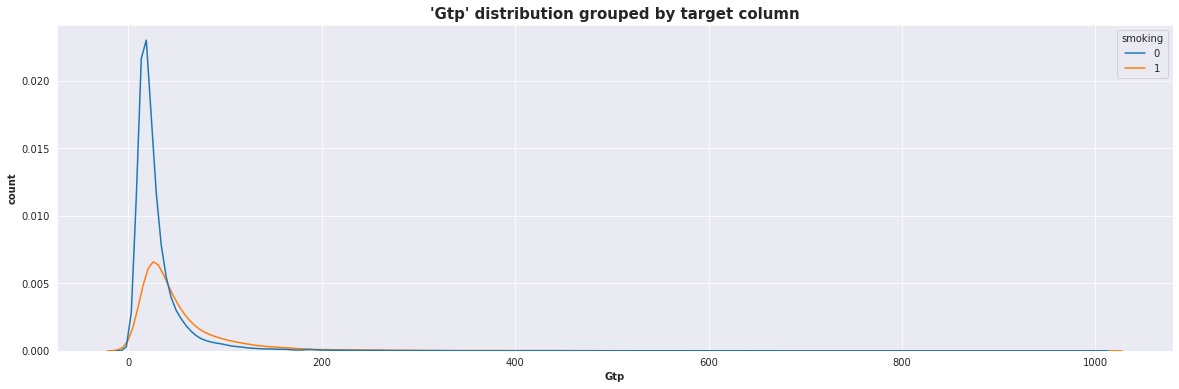

In [ ]:
plot_grouped('Gtp', discrete=False)

High Gtp -> higher chance of positive class.  
Again, outliers need to be handled.

In [ ]:
len(train.loc[train['Gtp'] > 200]) / len(train) * 100

1.3851836650933715

In [ ]:
len(train_clip.loc[train_clip['Gtp'] > 200]) / len(train_clip) * 100

1.0004234596654669

In [ ]:
train_clip = train_clip.loc[train_clip['Gtp'] < 200]

### dental caries

In [ ]:
train['dental caries'].value_counts(normalize=True)

0    0.7856
1    0.2144
Name: dental caries, dtype: float64

In [ ]:
train.groupby('dental caries')['smoking'].value_counts()

dental caries  smoking
0              0          20207
               1          10418
1              0           4459
               1           3900
Name: smoking, dtype: int64

In [ ]:
train.groupby('dental caries')['smoking'].value_counts(normalize=True)

dental caries  smoking
0              0          0.6598
               1          0.3402
1              0          0.5334
               1          0.4666
Name: smoking, dtype: float64

## Feature selection

### Chi-squared test of independence (categorical-categorical)

In [ ]:
cat_features

['hearing(left)', 'hearing(right)', 'dental caries']

In [ ]:
chi2_test = chi2(train_clip[cat_features], train_clip[TARGET])
display(pd.DataFrame(data={'chi2': chi2_test[0], 
                           'p-value': chi2_test[1]}, 
                     index=cat_features))

,chi2,p-value
hearing(left),0.4762,4.9014e-01
hearing(right),0.3373,5.6138e-01
dental caries,351.6974,1.8093e-78


Hearing-based features are independent of the target.

### ANOVA-F test (continuous-categorical)

In [ ]:
anova_test = f_classif(train_clip[num_features], train_clip[TARGET])
display(pd.DataFrame(data={'f-statistic': anova_test[0], 
                           'p-value': anova_test[1]}, 
                     index=num_features))

,f-statistic,p-value
age,1137.5295,1.1247e-245
height(cm),6977.9933,0.0000e+00
weight(kg),3819.8721,0.0000e+00
waist(cm),1984.7680,0.0000e+00
eyesight(left),139.7407,3.4615e-32
eyesight(right),175.6230,5.3883e-40
systolic,169.1981,1.3433e-38
relaxation,376.0730,2.2909e-83
fasting blood sugar,263.7507,4.1641e-59
Cholesterol,34.0082,5.5332e-09


'Urine protein' is rejected as a feature, since it has p-value above significance level (= 0.05).

In [ ]:
chi2(train_clip[['Urine protein']], train_clip[TARGET])

(array([0.11173109]), array([0.73818186]))

Even on treating 'Urine protein' as a categorical feature, it still has a p-value above significance level. Hence, it will be discarded as a feature.

### Mutual Information scores

In [ ]:
cat_mask = [f in cat_features for f in features] #boolean mask for discrete features
mi_scores = mutual_info_classif(train_clip[features], train_clip[TARGET], discrete_features=cat_mask, random_state=SEED)
display(pd.DataFrame(data={'mi_score': mi_scores}, index=features))

,mi_score
age,0.0227
height(cm),0.1069
weight(kg),0.0564
waist(cm),0.0298
eyesight(left),0.0047
eyesight(right),0.0060
hearing(left),0.0003
hearing(right),0.0002
systolic,0.0074
relaxation,0.0113


As expected, 'hearing(left)', 'hearing(right)' and 'Urine protein' have the lowest mutual information scores, along with 'Cholesterol' and 'LDL' which had lower scores in ANOVA test also.  
Thus, we will also drop 'Cholesterol' as a feature.
However, we saw a relation between 'LDL' and the target variable from the feature distribution. So we will retain it as a feature.

### Reduced features

In [ ]:
reduced_features = [f for f in features if f not in ('hearing(left)', 'hearing(right)', 'Cholesterol', 'Urine protein')]

In [ ]:
train[reduced_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  38984 non-null  int64   
 1   height(cm)           38984 non-null  int64   
 2   weight(kg)           38984 non-null  int64   
 3   waist(cm)            38984 non-null  float64 
 4   eyesight(left)       38984 non-null  float64 
 5   eyesight(right)      38984 non-null  float64 
 6   systolic             38984 non-null  int64   
 7   relaxation           38984 non-null  int64   
 8   fasting blood sugar  38984 non-null  int64   
 9   triglyceride         38984 non-null  int64   
 10  HDL                  38984 non-null  int64   
 11  LDL                  38984 non-null  int64   
 12  hemoglobin           38984 non-null  float64 
 13  serum creatinine     38984 non-null  float64 
 14  AST                  38984 non-null  int64   
 15  ALT                

# Baseline

In [ ]:
TREE_METHOD = 'gpu_hist' if GPU else 'hist'

baseline = xgb.XGBClassifier(
    n_estimators=1000,
    tree_method=TREE_METHOD,
    enable_categorical=GPU,
    max_cat_to_onehot=5,
    objective='binary:logistic',
    eval_metric='error',
    random_state=SEED)

### 1. All features, full dataset

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train[features], 
                                              train[TARGET],
                                              test_size=0.2,
                                              stratify=train[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
baseline.fit(
    xtrain, ytrain,
    verbose=0)

exp1_auc = roc_auc_score(yval, baseline.predict_proba(xval)[:, 1])
exp1_f1 = f1_score(yval, baseline.predict(xval))
print(f'Expmt-1: f1_score = {exp1_f1:.5f}, AUC = {exp1_auc:.5f}')

Expmt-1: f1_score = 0.71509, AUC = 0.87110


### 2. All features, clipped dataset

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train_clip[features], 
                                              train_clip[TARGET],
                                              test_size=0.2,
                                              stratify=train_clip[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
baseline.fit(
    xtrain, ytrain,
    verbose=0)

exp2_auc = roc_auc_score(yval, baseline.predict_proba(xval)[:, 1])
exp2_f1 = f1_score(yval, baseline.predict(xval))
print(f'Expmt-2: f1_score = {exp2_f1:.5f}, AUC = {exp2_auc:.5f}')

Expmt-2: f1_score = 0.70794, AUC = 0.86966


### 3. Reduced features, full dataset

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train[reduced_features], 
                                              train[TARGET],
                                              test_size=0.2,
                                              stratify=train[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
baseline.fit(
    xtrain, ytrain,
    verbose=0)

exp3_auc = roc_auc_score(yval, baseline.predict_proba(xval)[:, 1])
exp3_f1 = f1_score(yval, baseline.predict(xval))
print(f'Expmt-3: f1_score = {exp3_f1:.5f}, AUC = {exp3_auc:.5f}')

Expmt-3: f1_score = 0.71596, AUC = 0.87026


### 4. Reduced features, clipped dataset

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train_clip[reduced_features], 
                                              train_clip[TARGET],
                                              test_size=0.2,
                                              stratify=train_clip[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
baseline.fit(
    xtrain, ytrain,
    verbose=0)

exp4_auc = roc_auc_score(yval, baseline.predict_proba(xval)[:, 1])
exp4_f1 = f1_score(yval, baseline.predict(xval))
print(f'Expmt-4: f1_score = {exp4_f1:.5f}, AUC = {exp4_auc:.5f}')

Expmt-4: f1_score = 0.71305, AUC = 0.86983


The combination of reduced features and full dataset gives the best results for our baseline model. We will use it to generate test predictions.

# Test predictions

In [ ]:
baseline.fit(
    train[reduced_features], 
    train[TARGET],
    verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='error', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=5,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=2311, reg_alpha=0, reg_lambda=1, ...)

In [ ]:
predictions = baseline.predict(test[reduced_features])

In [ ]:
submission = pd.DataFrame({'smoking': predictions})
submission.to_csv('baseline_submission.csv', index=False)

In [ ]:
!head baseline_submission.csv

smoking
1
1
0
0
0
1
0
1
0
